# Исследование поездок на арендованных самокатах

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
    + абонентская плата отсутствует;
    + стоимость одной минуты поездки — 8 рублей;
    + стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    + абонентская плата — 199 рублей в месяц;
    + стоимость одной минуты поездки — 6 рублей;
    + стоимость старта — бесплатно.

**Цель проекта:** Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание данных:**

В основных данных есть информация о пользователях, их поездках и подписках.
* Пользователи — users_go.csv
    + user_id	уникальный идентификатор пользователя
    + name	имя пользователя
    + age	возраст
    + city	город
    + subscription_type	тип подписки (free, ultra)
* Поездки — rides_go.csv
    + user_id	уникальный идентификатор пользователя
    + distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    + duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    + date	дата совершения поездки
* Подписки — subscriptions_go.csv
    + subscription_type	тип подписки
    + minute_price	стоимость одной минуты поездки по данной подписке
    + start_ride_price	стоимость начала поездки
    + subscription_fee	стоимость ежемесячного платежа

**План работы:** Нужно загрузить и считать данные, провести их предобработку и исследовательский анализ данных, далее объединить их в один датафрейм и создать два типовых датафрейма, после чего подсчитать выручку по ним. После этого необходимо проверить гипотезы и посторить распределения. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial, sqrt

## Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:** В датафреймах отсутсвуют пропуски. Необходимо изменить тип данных столбца date.

## Предобработка данных

In [9]:
# Изменим тип данных в столбце date датафрейма rides на корректный
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [10]:
# Добавим столбец month с номером месяца на основе столбца date.
rides['month'] = rides['date'].dt.month
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [11]:
print(rides['date'].min(), rides['date'].max())

2021-01-01 00:00:00 2021-12-30 00:00:00


In [12]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [14]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [15]:
users.duplicated().sum()

31

In [16]:
users = users.drop_duplicates()

In [17]:
users.duplicated().sum()

0

In [18]:
rides.duplicated().sum()

0

In [19]:
subscriptions.duplicated().sum()

0

**Вывод:** Пропущенных значений обнаружено не было. В датафрейме users был найден и удален 31 дубликат.

## Исследовательский анализ данных

##### Частота встречаемости городов

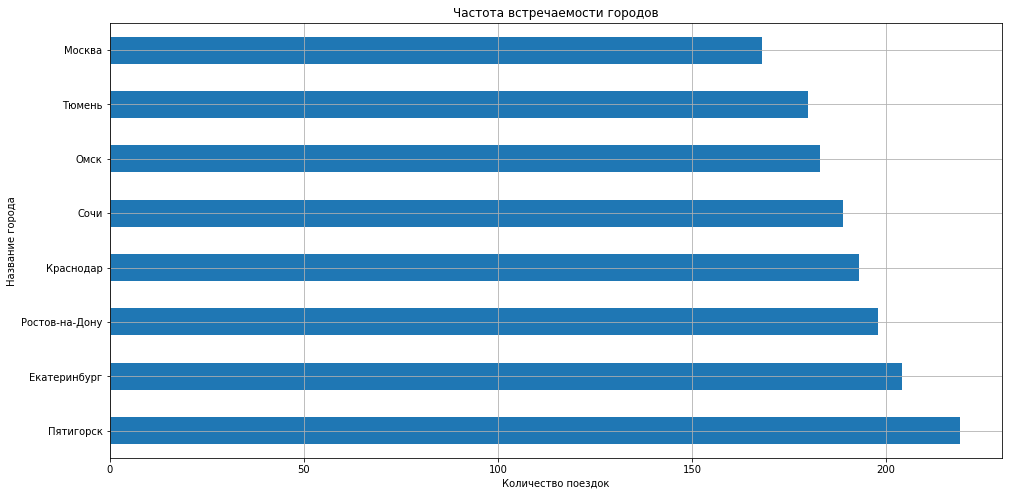

In [20]:
users['city'].value_counts().plot(kind='barh', grid=True, figsize=(16, 8))
plt.title('Частота встречаемости городов')
plt.xlabel('Количество поездок')
plt.ylabel('Название города')
plt.show()

In [21]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Частота встречаемости городов сравнима друг с другом (нет сильных выбросов), а также расположена в районе 200 поездок.

##### Соотношение пользователей с подпиской и без подписки

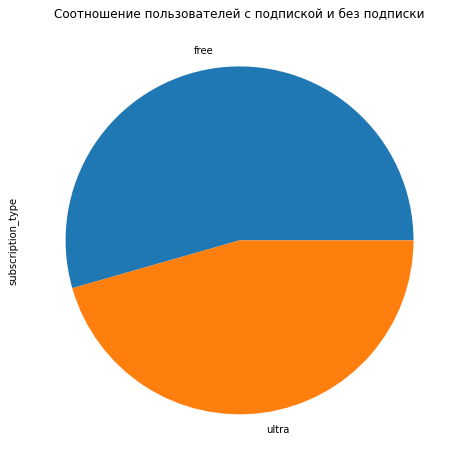

In [22]:
users['subscription_type'].value_counts().plot(kind='pie', grid=True, figsize=(16, 8))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()


In [23]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [24]:
par = users['subscription_type'].value_counts()
dic = {'free':par[0]/(par[0] + par[1]), 'ultra':par[1]/(par[0] + par[1])}
dic

{'free': 0.5443285528031291, 'ultra': 0.4556714471968709}

Колиечство пользователей с подпиской и без подписки примерно равно, но пользователей без подписки немного больше.

##### Возраст пользователей

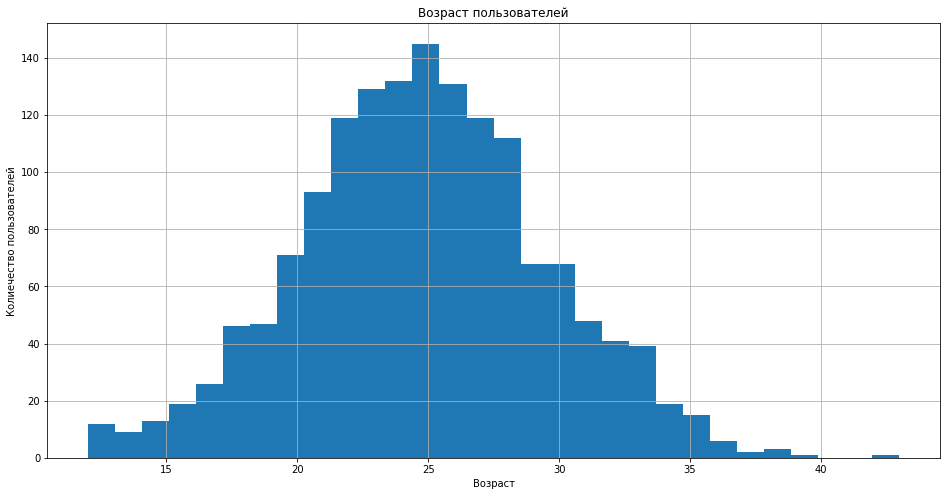

In [25]:
users['age'].hist(bins=30, figsize=(16, 8))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Колиечество пользователей')
plt.show()

In [26]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст пользователей имеет нормалное распределение со средним значением около 25 лет. Также в гистограмме встречаются выбоены, можно сделать вывод о том, что данных недостаточно.

##### Расстояние, которое пользователь преодолел за одну поездку

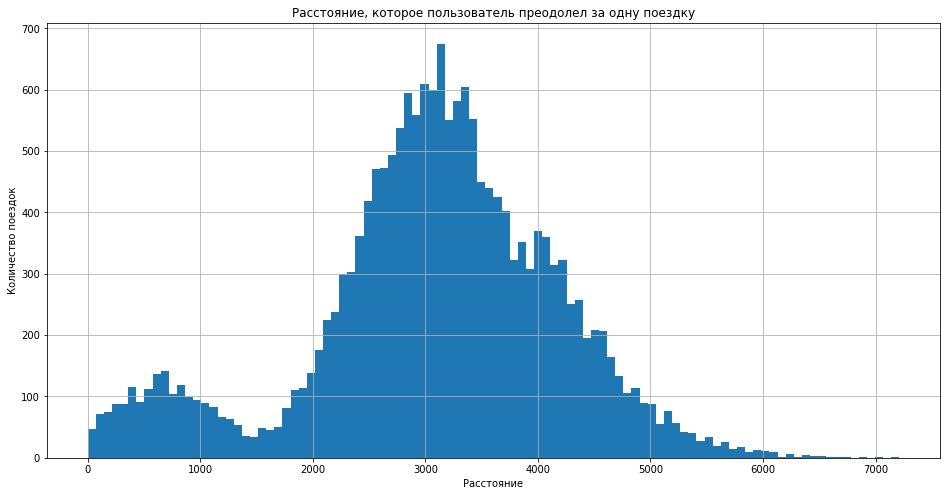

In [27]:
rides['distance'].hist(bins=100, figsize=(16, 8))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

In [28]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

На гистограмме видны два локальных пика в районе 600-700 и 3133 метров. Можно предположить, что левый пик появился в результате того, что пользователь по какой-либо причине предеумал ехать до конечного пункта или же, наоборот, он находился слишком близко, но тогда неясно почему значений на уровне 1500 так мало. Среднее расстояние в 3133 метров кажется более правдоподобным.

##### Продолжительность поездок

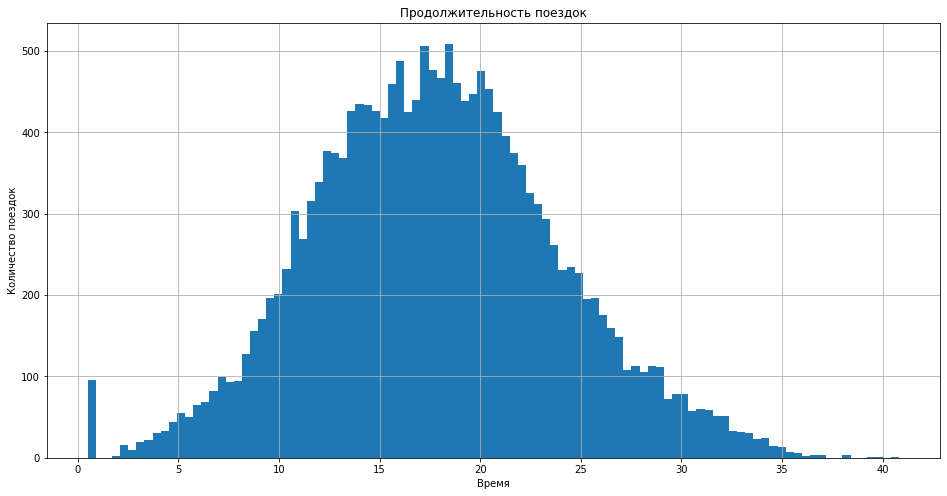

In [29]:
rides['duration'].hist(bins=100, figsize=(16, 8))
plt.title('Продолжительность поездок')
plt.xlabel('Время')
plt.ylabel('Количество поездок')
plt.show()

In [30]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Наблюдается выброс в районе первой минуты, можно сделать вывод о том, что самокат был взят по ошибке или было принято решение использовать другой вид передвижения. В среднем же время поездки составляет от 13 до 22 минут.

**Вывод:** 
Частота встречаемости городов сравнима друг с другом и лежит в районе 200 поездок. Колиечство пользователей с подпиской и без подписки примерно одинаково, но пользователей без подписки на примерно на 10% больше.
Средний возраст пользователя равен 25 лет. 
На гистограмме видны два локальных пика в районе 600-700 и 3133 метров. Можно предположить, что левый пик появился в результате того, что пользователь по какой-либо причине предеумал ехать до конечного пункта или же, наоборот, он находился слишком близко, но тогда неясно почему значений на уровне 1500 так мало. Среднее расстояние в 3133 метров кажется более правдоподобным.
Наблюдается выброс в районе первой минуты, можно сделать вывод о том, что самокат был взят по ошибке или было принято решение использовать другой вид передвижения. В среднем же время поездки составляет от 13 до 22 минут.

##  Объединение данных

##### Объединение данных о пользователях, поездках и подписках в один датафрейм. 

In [31]:
data = rides
data = data.merge(users, on='user_id', how='left')
data = data.merge(subscriptions, on='subscription_type', how='left')

In [32]:
data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Объединение прошло корректно. Количество поездок из датафрейма rides совпадает с количеством строк в объединенном датафрейме. Значений в столбце user_id также совадает. Пропуски отсутствуют.

##### Создание новых датафреймов на основе подписки

######  Создание датафрейма c данными о пользователях без подписки


In [34]:
unsubs = data[data['subscription_type'] == 'free']
unsubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


###### Создание датафрейма c данными о пользователях с подпиской


In [35]:
subs = data[data['subscription_type'] == 'ultra']
subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.


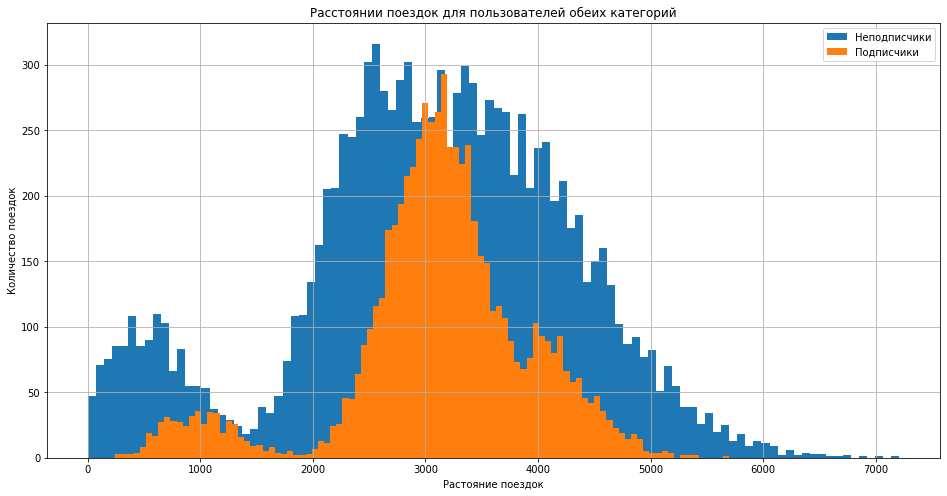

In [36]:
plt.figure(figsize=(16,8))
plt.hist(unsubs['distance'], alpha=1, bins=100, label='Неподписчики')
plt.hist(subs['distance'], alpha=1, bins=100, label='Подписчики')
plt.grid(True)
plt.title('Расстоянии поездок для пользователей обеих категорий')
plt.xlabel('Растояние поездок')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [37]:
subs['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [38]:
unsubs['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

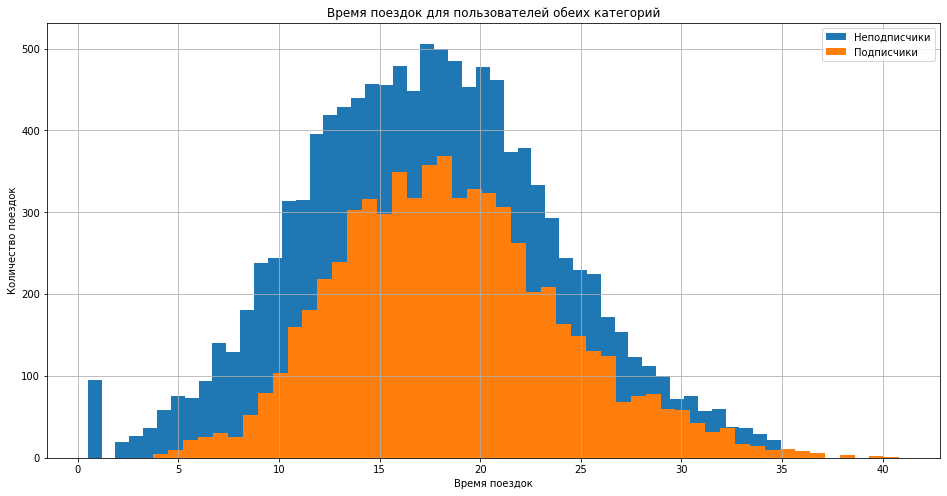

In [39]:
plt.figure(figsize=(16,8))
plt.hist(unsubs['duration'], alpha=1, bins=50, label='Неподписчики')
plt.hist(subs['duration'], alpha=1, bins=50, label='Подписчики')
plt.grid(True)
plt.title('Время поездок для пользователей обеих категорий')
plt.xlabel('Время поездок')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [40]:
subs['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [41]:
unsubs['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

**Вывод:** На данном этапе три отдельных датафрейма были объединены в один общий, после чего тот был разделен на два датафрейма по типу подписки. Также были построены гистограмы полученных датафреймов и сделаны следующие выводы: у пользователей без подписки бОльший диапазон расстояния поездок и чаще встречаются короткие поездки (до 500 м). У пользователей без подписки чуть бОльший разброс (это видно на графике, а также при сравнении стандартного отклонения (6.33 > 5.57)). 
Среднее расстояние пользователей с подпиской больше на 70 метров (3115 - 3045), а медина на 34 метра (3148 - 3114).
Если говорить о врмени, то тут то же отличие в сторону пользователей, имеющих подписку: 1.15 мину (18.54 - 17.39) по среднему и 0.85 минут по медиане (18.18 - 17.33).
Графики имееют схожее распределение, однако гистогрммы пользователей с подпиской имеют меньший разброс по оси абсцисс. 

## Подсчёт выручки

In [42]:
data.head(15)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


##### Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными

In [44]:
# Округляем продолжительность поездки
data['duration'] = np.ceil(data['duration']).astype('int')

In [45]:
agg_data = data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['count', 'sum'])
agg_data.columns = ['rides_count', 'to_drop', 'sum_distance', 'sum_duration']
agg_data.pop('to_drop')
agg_data.head(20)

rides_count  sum_distance  sum_duration
user_id month                                         
1       1                2   7027.511294            42
        4                1    754.159807             7
        8                2   6723.470560            46
        10               2   5809.911100            32
        11               3   7003.499363            56
        12               2   6751.629942            28
2       3                3  10187.723006            63
        4                2   6164.381824            40
        6                1   3255.338202            14
        7                2   6780.722964            48
        8                1    923.007439             7
        10               1   2824.636598            19
        12               1   3828.248580            12
3       1                1   3061.777147            13
        2                2   5421.152016            39
        4                1   2956.651632            21
        5                3   9064.026918            63
        7                3  10919.595403            67
        9                1   2891.012822            23
        12               1   2593.381928            13

##### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь

In [46]:
# Заметим, что user_id пользователей с подпиской <= 699 (4533 строки), а без подписки >= 700 (оставшиеся)
#agg_data['month_prof'] = agg_data['sum_duration']*6 + 199
#agg_data[4533:]['month_prof'] = agg_data['rides_count']*50 + agg_data['sum_duration']*8
#agg_data

In [47]:
agg_data = data.pivot_table(
    index=['user_id', 'month'], 
    values=['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee', 'distance', 'duration'], 
    aggfunc=['first', 'count', 'sum']
)
agg_data.columns = [1, 2, 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type', 
'rides_count', 8, 9, 10, 11, 12, 'sum_distance', 'sum_duration', 15, 16, 17]
#test_data['count']['distance']

agg_data.drop([1, 2, 8, 9, 10, 11, 12, 15, 16, 17], axis=1, inplace=True)
agg_data


minute_price  start_ride_price  subscription_fee  \
user_id month                                                     
1       1                 6                 0               199   
        4                 6                 0               199   
        8                 6                 0               199   
        10                6                 0               199   
        11                6                 0               199   
...                     ...               ...               ...   
1534    6                 8                50                 0   
        8                 8                50                 0   
        9                 8                50                 0   
        11                8                50                 0   
        12                8                50                 0   

              subscription_type  rides_count  sum_distance  sum_duration  
user_id month                                                             
1       1                 ultra            2   7027.511294            42  
        4                 ultra            1    754.159807             7  
        8                 ultra            2   6723.470560            46  
        10                ultra            2   5809.911100            32  
        11                ultra            3   7003.499363            56  
...                         ...          ...           ...           ...  
1534    6                  free            2   3409.468534            26  
        8                  free            2   7622.453034            48  
        9                  free            1   4928.173852            23  
        11                 free            4  13350.015305            78  
        12                 free            1   2371.711192            16  

[11331 rows x 7 columns]

In [48]:
agg_data['month_prof'] = (
    agg_data['start_ride_price'] * agg_data['rides_count'] +
    agg_data['minute_price'] * agg_data['sum_duration'] + 
    agg_data['subscription_fee']
)
agg_data

minute_price  start_ride_price  subscription_fee  \
user_id month                                                     
1       1                 6                 0               199   
        4                 6                 0               199   
        8                 6                 0               199   
        10                6                 0               199   
        11                6                 0               199   
...                     ...               ...               ...   
1534    6                 8                50                 0   
        8                 8                50                 0   
        9                 8                50                 0   
        11                8                50                 0   
        12                8                50                 0   

              subscription_type  rides_count  sum_distance  sum_duration  \
user_id month                                                              
1       1                 ultra            2   7027.511294            42   
        4                 ultra            1    754.159807             7   
        8                 ultra            2   6723.470560            46   
        10                ultra            2   5809.911100            32   
        11                ultra            3   7003.499363            56   
...                         ...          ...           ...           ...   
1534    6                  free            2   3409.468534            26   
        8                  free            2   7622.453034            48   
        9                  free            1   4928.173852            23   
        11                 free            4  13350.015305            78   
        12                 free            1   2371.711192            16   

               month_prof  
user_id month              
1       1             451  
        4             241  
        8             475  
        10            391  
        11            535  
...                   ...  
1534    6             308  
        8             484  
        9             234  
        11            824  
        12            178  

[11331 rows x 8 columns]

**Вывод:** На данном этапе был создан новый датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предидущего шага, в котором было найдено: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Далее в этот датафрейм был добавлен столбец с помесячной выручкой, которую принёс каждый пользователь.

##  Проверка гипотез

##### Гипотеза о "выгодности" пользователй с подпской
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
* Нулевая гипотеза: среднее время поездок пользователей с подпиской и без равны
* Альтернативная гипотеза: пользователи с подпиской тратят больше времени, чем пользователи без подписки.

In [49]:
alpha = 0.05
resluts_1 = st.ttest_ind(subs['duration'], unsubs['duration'], alternative='greater')

print(f'P-value: {resluts_1.pvalue}')
if resluts_1.pvalue < alpha: print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')

P-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


На основе проведенного теста можно предположить, что пользователи с подпиской тратят больше времени, чем пользователи без нее.

In [50]:
print('Среднее количество времени, которое тратят пользователи с подпиской:', subs['duration'].mean())
print('Среднее количество времени, которое тратят пользователи без подписки:', unsubs['duration'].mean())

Среднее количество времени, которое тратят пользователи с подпиской: 18.54198516280583
Среднее количество времени, которое тратят пользователи без подписки: 17.39090929866399


##### Гипотеза о среднем расстоянии
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.
* Нулевая гипотеза: среднее расстояние одной поездки равно 3130 метров
* Альтернативная гипотеза: среднее расстояние одной поездки превышает 3130 метров

In [51]:
value = 3130
results_2 = st.ttest_1samp(subs['distance'], value, alternative='greater')

print(f'P-value: {results_2.pvalue}')
if results_2.pvalue < alpha: print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


На основе проведенного теста можно предположить, что среднее расстояние которое проезжают пользователи с подпиской за одну поездку может находится около 3130 метров или меньше.

In [52]:
print('Среднее расстояние которое проезжают пользователи с подпиской', subs['distance'].mean())

Среднее расстояние которое проезжают пользователи с подпиской 3115.4453880370247


##### Гипотеза о влиянии подписки на помесячную выручку
Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.
* Нулевая гипотеза: помесячная выручка от пользователей с подпиской равнв выручке от пользователей без подписки
* Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

In [53]:
subs_agg = agg_data[agg_data['subscription_type'] == 'ultra']
unsubs_agg = agg_data[agg_data['subscription_type'] == 'free']

results_3 = st.ttest_ind(subs_agg['month_prof'], unsubs_agg['month_prof'], alternative='greater')

print(f'P-value: {results_3.pvalue}')
if results_3.pvalue < alpha: print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')

P-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


На основе проведенного теста можно предположить, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [54]:
print('Средняя помесячная выручка от пользователей с подпиской', subs_agg['month_prof'].mean())
print('Средняя помесячная выручка от пользователей без подписки', unsubs_agg['month_prof'].mean())

Средняя помесячная выручка от пользователей с подпиской 362.7921906022502
Средняя помесячная выручка от пользователей без подписки 328.6413651073845


##### Гипотеза о количестве обращений
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
* Нулевая гипотеза: из-за обновления сервера количество обращений в техподдержку не изменилось
* Альтернативная гипотеза: из-за обновления сервера количество обращений в техподдержку снизилось

Так как мы имеем дело с зависимой (парной) выборкой, то следует использовать тест st.ttest_rel(количестве обращений до обновления, количестве обращений после обновления) 

**Вывод:** Были рассмотрены три гипотезы, на основании которых можно сделать следющие выводы:
* Пользователи с подпиской могут больше времени, чем пользователи без нее.
* Среднее расстояние которое проезжают пользователи с подпиской за одну поездку может лежать находистя рядом с 3130 метров.
* Помесячная выручка от пользователей с подпиской может быть выше, чем выручка от пользователей без подписки.

##  Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 1001 artists>

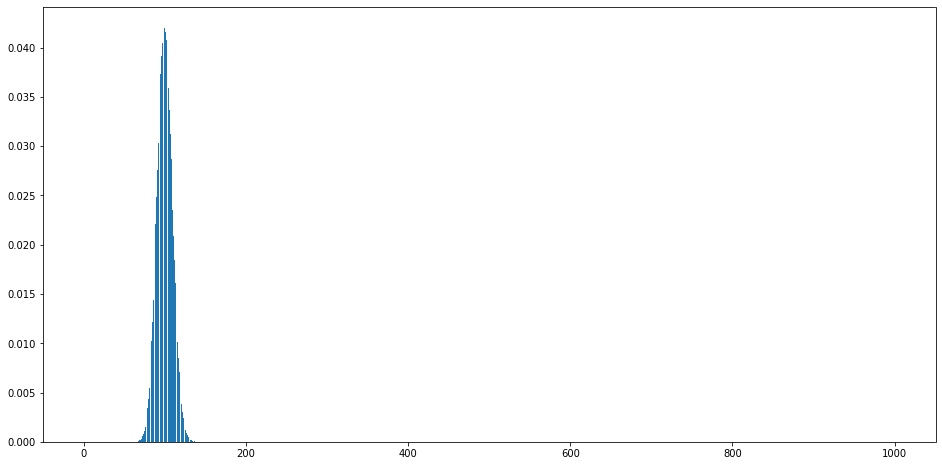

In [55]:
n = 1000
p = 0.1
distr = []

for k in range(0, n+1):
    choose = factorial(n) / (factorial(n-k) * factorial(k))
    prob = choose * p**k * (1-p)**(n-k)
    distr.append(prob)
    
plt.figure(figsize=(16,8))  
plt.bar(range(0, n+1), distr)

In [56]:
for n in range(800, 1200):
    mu = n * p
    sigma = sqrt(n * p * (1-p))
    distr = st.norm(mu, sigma)
    result = distr.cdf(99)
    if result <= 0.05:
        print(n)
        break

1158


**Ответ:** минимальное количество промокодов, которое нужно разослать - 1158

##### 
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

<BarContainer object of 1001 artists>

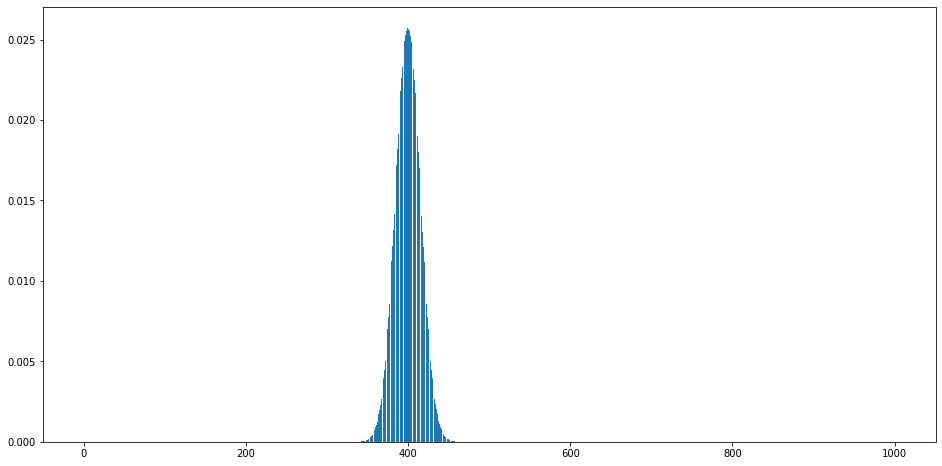

In [57]:
n = 1000
p = 0.4
distr = []

for k in range(0, n+1):
    choose = factorial(n) / (factorial(n-k) * factorial(k))
    prob = choose * p**k * (1-p)**(n-k)
    distr.append(prob)
    
plt.figure(figsize=(16,8))  
plt.bar(range(0, n+1), distr)

In [58]:
n = 1000000
p = 0.4
mu = n * p
sigma = sqrt(n * p * (1-p))

distr = st.norm(mu, sigma)
result = distr.cdf(399500)
result

0.15371708296369768

**Ответ:** вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна примерно 15.3%

##  Итоговый вывод
Были рассмотрены данные из трех файлов (users_go.csv, rides_go.csv, subscriptions_go.csv). Пропуски отсутсвуют. Дубликаты, найденные в датафрейме users, удалены.

На этапе исселодвательского анализа данных были получены следюущие результаты.
Частота встречаемости городов сравнима друг с другом и лежит в районе 200 поездок. Колиечство пользователей с подпиской и без подписки примерно одинаково, но пользователей без подписки на примерно на 10% больше.
Средний возраст пользователя равен 25 лет. 
На гистограмме видны два локальных пика в районе 600-700 и 3133 метров. Можно предположить, что левый пик появился в результате того, что пользователь по какой-либо причине предеумал ехать до конечного пункта или же, наоборот, он находился слишком близко, но тогда неясно почему значений на уровне 1500 так мало. Среднее расстояние в 3133 метров кажется более правдоподобным.
Наблюдается выброс в районе первой минуты, можно сделать вывод о том, что самокат был взят по ошибке или было принято решение использовать другой вид передвижения. В среднем же время поездки составляет от 13 до 22 минут.

На этапе объединения данных три отдельных датафрейма были соезинены в один общий, после чего тот был разделен на два датафрейма по типу подписки. Также были построены гистограмы полученных датафреймов и сделаны следующие выводы: у пользователей без подписки бОльший диапазон расстояния поездок и чаще встречаются короткие поездки (до 500 м). У пользователей без подписки чуть бОльший разброс (это видно на графике, а также при сравнении стандартного отклонения (6.33 > 5.57)). 
Среднее расстояние пользователей с подпиской больше на 70 метров (3115 - 3045), а медина на 34 метра (3148 - 3114).
Если говорить о врмени, то тут то же отличие в сторону пользователей, имеющих подписку: 1.15 мину (18.54 - 17.39) по среднему и 0.85 минут по медиане (18.18 - 17.33).
Графики имееют схожее распределение, однако гистогрммы пользователей с подпиской имеют меньший разброс по оси абсцисс. 

В заключительном этапе были рассмотрены три гипотезы, на основании которых можно сделать следющие выводы:
* Пользователи с подпиской могут больше времени, чем пользователи без нее.
* Среднее расстояние которое проезжают пользователи с подпиской за одну поездку может лежать находистя рядом с 3130 метров.
* Помесячная выручка от пользователей с подпиской может быть выше, чем выручка от пользователей без подписки.

Пользователи с подпиской являются более выгодными для сервиса аренды самокатов, чем пользователи без нее!